In [1]:
# @author Matthew Sit

import numpy as np
import scipy.stats as stat
import os
from noisyopt import minimizeCompass
from scipy.optimize import minimize
from heapq import heappush, heappop
import matplotlib.pyplot as plt
import operator
import pickle
from operator import itemgetter
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
import csv
import h5py 

if "analyze" in os.getcwd():
    os.chdir("../")


# Parameters that can be changed

In [3]:

# parser = argparse.ArgumentParser(description='Analyze P Parllel')
# parser.add_argument('--model', type=str, required=True, help='specifies model for AnalyzeP')
# parser.add_argument('--peeling', type=str, required=True, help='specifies peeling for AnalyzeP')
# parser.add_argument('--CURRENTDATE', type=str, required=True, help='specifies date')
# parser.add_argument('--custom', type=str, required=False, help='specifies custom postfix')

#args = parser.parse_args()
model = "bbp" #args.model
peeling = "sodium" #args.peeling
currentdate = "03_06_2021" #args.CURRENTDATE
custom = "full"

# Data Files
if custom is not None:
    wrkDir = 'runs/' + model + '_' + peeling + '_' + currentdate + custom
else:
    wrkDir = 'runs/' + model + '_' + peeling + '_' + currentdate
opt_path = wrkDir + '/genetic_alg/optimization_results/opt_result_single_stim_' + model + '_' + peeling + '_full.hdf5'
save_path = wrkDir + '/genetic_alg/objectives'
if not os.path.isdir(save_path):
    os.mkdir(save_path)
params_path = 'params/params_' + model + '_' + peeling + '.hdf5'
scores_path =  wrkDir + '/scores/'
params_file = h5py.File(params_path, 'r')
opt_file = h5py.File(opt_path, 'r')
scores_path

'runs/bbp_sodium_03_06_2021full/scores/'

In [4]:
# Constants 
coarseStepSize = 0.1
fineStepSize = 0.01

# Value in range [0, 1] reflecting percent of data to use for training.
# 1 - proportionToTrain will be used for validation.
proportionToTrain = 0.7

# Integer in range [1, len(stim_names)].
# The number of top stims to use for multi-stim optimization.
# If k = 1, then use the top stim only.
k = 1

# random seed to use for train/validation on optimization
seed = 500

# Weights for optimization.
# obj_comb_vec is vector of weights for [spearman, mean, standard deviation].
# In general, we want to maximize spearman, maximize mean, and minimize standard deviation.

score_function_list = [e.decode('ascii') for e in opt_file['ordered_score_function_list'][:]]

In [5]:
# Dump these parameters to a pickle file so that
# they can be used by the utility script file
# when it is run in the next section.

with open("params.pkl", 'wb') as f:
    pickle.dump([
        scores_path,
        params_path,
        score_function_list,
        coarseStepSize,
        fineStepSize
    ], f)

## START HERE

below is a local notebook version of newAnalyzep.py. The goal is to replace minimizecompass (https://noisyopt.readthedocs.io/en/latest/api.html) in optimize function with another faster score function from scipy (https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html) that you think is good. A good RQ to start with :) 

In [6]:
# @author Kyung Geun Kim

import numpy as np
import scipy.stats as stat
import os
from noisyopt import minimizeCompass
from scipy.optimize import minimize
from heapq import heappush, heappop
from importlib import reload
import loadParamsPkl
reload(loadParamsPkl)
from loadParamsPkl import *
import warnings
import h5py

eta = 1e-100
scores_path =  wrkDir + '/scores/'

def construct_stim_score_function_list(scores_path):
    stim_list = []
    file_list = os.listdir(scores_path)
    for file_name in file_list:
        if '.hdf5' in file_name:
            curr_scores = h5py.File(scores_path + file_name, 'r')
            stim_list.append(curr_scores['stim_name'][0].decode('ascii'))
            score_function_list = [e.decode('ascii') for e in curr_scores['score_function_names'][:]]
    return sorted(stim_list), sorted(score_function_list)

def construct_score_sensitivity_dict(ordered_stim_list, ordered_score_function_list):
    norm_score_prefix = 'norm_pin_scores_'
    pin_score_dict = {}
    for stim in ordered_stim_list:
        score_file_name = stim + '_scores.hdf5'
        score_file = h5py.File(scores_path + score_file_name, 'r')
        curr_pin_list = []
        for function_name in ordered_score_function_list:
            curr_pin_score = score_file[norm_score_prefix+function_name][:].T[0]
            pin_len = len(curr_pin_score)
            curr_pin_list.append(curr_pin_score)
        pin_score_dict[stim] = curr_pin_list
    return pin_score_dict

# Returns an objective for the optimization problem.
# obj_comb_vec is vector of weights for [spearman, mean, standard deviation].
def construct_objective(score_mat):
    perfect_distribution = np.arange(np.shape(score_mat)[1])
    def obj(x):
       # Vector x is the weight vector where dot product with score vector and
       # argmin of objective will be the optimal linear combination
        x = x[np.newaxis]
        spearman = (stat.spearmanr(np.dot(x, score_mat).reshape((len(perfect_distribution))), perfect_distribution))[0]
        #print('Spearman: ', spearman/8)
        #print('Mean: ', mean)
        #print('Standard Deviation: ', 3*std)
        #print('Total: ', -spearman/8 - mean + 3*std, '\n')
        return -spearman
    return obj

# Runs optimization algorithm with the stim list and maximum bound as an input
# Can be used for both single stim and multi stim optimization.
# @argument stim_name_list can be either the name of a single stim,
# or a list of stim names if multi-stim optimization desired.
def optimize(stim_name_list, subset_list=None, min_bound = 0, max_bound = 100):
    if isinstance(stim_name_list, str):
        # Single stim optimization.
        stim_name_list = [stim_name_list]
    else:
        # Multi stim optimization.
        # Already a list, nothing to be done to stim_name_list.
        pass

    score_mat = np.concatenate(tuple([pin_score_dict[n] for n in stim_name_list]), axis=0)
    # Use only a subset of the data points if provided.
    # Otherwise, use all of the data points still.
    if subset_list is not None:
        score_mat = np.take(score_mat,subset_list,1)
    ####################################################################################
    # start here!!
    optimizer_len = np.shape(score_mat)[0]
    bound = [[min_bound, max_bound] for _ in range(optimizer_len)]
    np.random.seed(0)
    initial_guess = np.array([np.random.random_sample()*100 for _ in range(optimizer_len)])
    obj = construct_objective(score_mat)
   
    return minimizeCompass(obj, bounds=bound, x0=initial_guess, deltainit = 100, deltatol=0.01, paired=False), score_mat, obj
    #return minimize(obj, bounds=bound, x0=initial_guess), score_mat, obj
    ####################################################################################

def greedy_multistim_optimize(single_opt_sorted, num_stims):
    stim_name_list = [single_opt_sorted[i][0] for i in range(num_stims)]
    return optimize(stim_name_list)

try:
    ordered_stim_list, ordered_score_function_list = construct_stim_score_function_list(scores_path)
    pin_score_dict = construct_score_sensitivity_dict(ordered_stim_list, ordered_score_function_list)

except FileNotFoundError:
    warnings.warn("Warning: Dictionaries not created because required files not found.\nSee the `~/analyzeP` directory for sample required files.",
        RuntimeWarning)
    


def main():
    return ordered_stim_list, ordered_score_function_list, pin_score_dict


params.pkl successfully loaded.
params.pkl successfully loaded.


In [7]:
ordered_stim_list, ordered_score_function_list, pin_score_dict = main()

In [8]:
# Fixes a shuffled order.
# Applies the same shuffled order on fed data.
# After shuffling, you can use say the first 70% for training and the last 30% for validation.
def fix_shuffled_subset_list(length):
    shuffle_pattern = np.arange(length)
    np.random.shuffle(shuffle_pattern)
    def subset_list(subset=None):
        if subset is 'train':
            return sorted(shuffle_pattern[:int(length*proportionToTrain)])
        elif subset is 'test':
            return sorted(shuffle_pattern[int(length*proportionToTrain):])
        else:
            return shuffle_pattern
    return subset_list

<>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-8-66bf52533e62>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if subset is 'train':
<ipython-input-8-66bf52533e62>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif subset is 'test':


In [9]:
# Plots the sensitivity matrix as a heat map. 
# Vertical axis is the parameter index and 
# Horizontal axis is the numbering of each param set.
def plot_heat_map(mat, stim='', sf=''):
    # Heat Map for all elementary effects.
    #['gna_dend','gna_node','gna_soma','gkv_axon','gkv_soma','gca_dend','gkm_dend','gkca_dend','gca_soma','gkm_soma','gkca_soma','depth_cad']
    data = mat.T
    plt.imshow(data, cmap='RdBu_r', aspect='auto')
    ax = plt.gca()
    ax.invert_yaxis()
#    if stim is 'Weighted matrix':
    #plt.title('Weighted matrix', fontsize=15)
#     else:
    plt.title('Elementary effect for ' + stim + ' input\n and ' + sf + ' score function', fontsize=15)
    plt.ylabel('Parameter set', fontsize=18)
    plt.xlabel('Parameter name', fontsize=18)
    plt.colorbar()
    #plt.savefig('./heat_map_potassium.eps', format='eps', dpi=1000)
    plt.show()

In [10]:
def compute_lin_comb_mat(stim_name, weight_vector, sensitivity_dict):
    return sum([sensitivity_dict[stim_name][i]*weight_vector[i] for i in range(len(weight_vector))])

def plot_lin_comb_as_heat_map(stim_name, weight_vector, sensitivity_dict):
    if isinstance(stim_name, str):
        # Single stim.
        lin_comb_mat = compute_lin_comb_mat(stim_name, weight_vector, sensitivity_dict)
        print('Weighted Mat: ')
        plot_heat_map(lin_comb_mat, stim_name)
    else:
        # Multi-stim.
        lin_comb_mat = sum([
            compute_lin_comb_mat(stim_name[i], weight_vector[i*len(score_function_list):(i+1)*len(score_function_list)], sensitivity_dict) for i in range(len(stim_name))])

        plot_heat_map(lin_comb_mat, '\n & '.join(stim_name))

In [11]:
stimsInOrder = [e.decode('ascii') for e in opt_file['stims_optimal_order'][:]]

## Training & Validation on Score Optimization

In [12]:
# @arg stim_name can either be the name of a single stim, or it can be a list of multiple stim names.
# In the latter case, optimize will be run in multi-stim mode.
def trainAndValidateScoreOptimization(stim_name, showHeatMap=False, seed=500, verbosity=True, saveToFile=False):
    np.random.seed(seed)

    if verbosity:
        plt.figure(figsize=(15,7))
        plt.title('Optimal weighted scores for ' + '\n & '.join(stim_name))
        plt.xlabel('Parameter Set Rank')
        plt.ylabel('Optimization value')

    if isinstance(stim_name, str):
        N = len(pin_score_dict[stim_name][0])
    else:
        NForEachStim = [len(pin_score_dict[single_stim][0]) for single_stim in stim_name]
        # Each of the stims in the list must be of the same length!
        assert all(N == NForEachStim[0] for N in NForEachStim), 'Each stim is not of the same length.'
        N = NForEachStim[0]
    
    # Create a pattern and use the pattern to select indices of training and testing data.
    shuffle_pattern = fix_shuffled_subset_list(N)
    training = shuffle_pattern('train')
    testing = shuffle_pattern('test')

    # Optimize on the training set.
    ######### Calls function we need to start #########
    train_result, train_score_mat, _ = optimize(stim_name, training)
    train_result = train_result.x
    if verbosity:
        plt.scatter(training, train_result @ train_score_mat, label='Training Data')
        plt.plot(training, np.poly1d(np.polyfit(training, train_result @ train_score_mat, 1))(training))
    
    # Optimize on the entire set to establish a ground truth.
    test_result, test_score_mat, _ = optimize(stim_name)
    # Optimize on the testing set to establish a ground truth.
    #test_result, test_score_mat, _ = optimize(stim_name, testing, obj_comb_vec = obj_comb_vec)
    test_result = test_result.x
    if verbosity:
        plt.scatter(np.arange(N), train_result @ test_score_mat, label='Testing Data')
        plt.plot(np.arange(N), np.poly1d(np.polyfit(np.arange(N), train_result @ test_score_mat, 1))(np.arange(N)))
        #plt.scatter(np.arange(N), test_result @ test_score_mat, label='Ground Truth Test')
        #plt.plot(np.arange(N), np.poly1d(np.polyfit(np.arange(N), test_result @ test_score_mat, 1))(np.arange(N)))
    
        # Replot training and testing data on top of ground truth data.
        plt.scatter(np.arange(N), train_result @ test_score_mat, color='C1')
        plt.scatter(training, train_result @ train_score_mat, color='C0')
    
        # Print stims used, which were the top k stims.
        if len(stim_name) == 1:
            print('Single stim optimization:', stim_name[0])
        else:
            print('Top', min(k, len(stim_name)), 'stims:', stim_name)
        print()
        
        # Print weights
        print('Each row belongs to a single stim.')
        print('Training Weights:\n', train_result.reshape([min(k, len(stim_name)), len(score_function_list)]))
        print('Ground Truth Weights:\n', test_result.reshape([min(k, len(stim_name)), len(score_function_list)]))
        print()

        # Print spearman scores for the three sets of sampled data.
        print('Training Spearman:', round(stat.spearmanr(np.asarray(training), train_result @ train_score_mat)[0], 5))
        print('Testing Spearman:', round(stat.spearmanr(np.arange(N), train_result @ test_score_mat)[0], 5))
        print('Ground Truth Spearman:', round(stat.spearmanr(np.arange(N), test_result @ test_score_mat)[0], 5))

        plt.legend()
        #plt.savefig('./trainset_and_groundtruth_potassium.eps', format='eps', dpi=1000)
        plt.show()

#     if showHeatMap:
#         plot_lin_comb_as_heat_map(stim_name, train_result, sensitivity_dict)
        
#     if saveToFile:
#         # Save the ground truth weights reshaped into a single vector.
#         #np.savetxt("optimal_weight_list.csv", test_result.reshape([1, test_result.shape[0]]), delimiter=",")
        
#         # Save the stim names used in this optimization.
#         with open("optimal_stim_list.csv", 'w') as f:
#             wr = csv.writer(f, quoting=csv.QUOTE_ALL, delimiter=" ")
#             wr.writerow(stim_name)
        
    # Return weights
    stims_optimal_order = [np.string_(e) for e in stim_name]
    return np.array(test_result.reshape([1, test_result.shape[0]])), np.array(stims_optimal_order)

Single stim optimization: he_1_2_9

Each row belongs to a single stim.
Training Weights:
 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  1.00000000e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  6.03799479e+01 1.00000000e+02 7.81250000e-01 1.00000000e+02
  3.08105469e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 5.23437500e+01 1.00000000e+02
  0.00000000e+00 9.62890625e+01 0.00000000e+00 7.42187500e+01
  0.00000000e+00 4.88281250e-02 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.00000000e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 2.92968750e-01
  0.00000000e+00 0.00000000e+00 5.00000000e+01 2.46093750e+01
  4.88281250e-02 0.00000000e+00 0.00000000e+00 2.11425781e+01
  6.21093750e+01 0.00000000e+00 0.00000000e+00 8.02548304e+00
  6.53108325e+01 0.00000000e+00 5.56640625

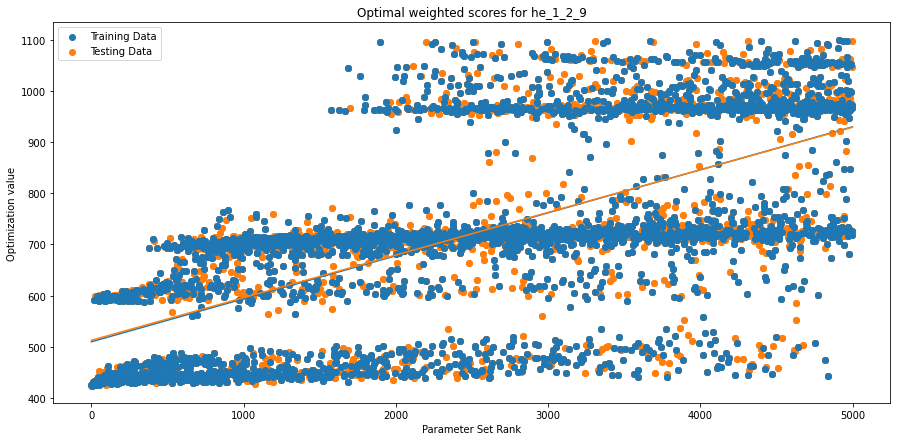

In [13]:
######### Calls function we need to start #########
weight_list, stim_list = trainAndValidateScoreOptimization(stimsInOrder[:k], True, seed=seed, saveToFile=True)

In [13]:
opt_result_hdf5 = h5py.File(save_path +'/multi_stim_without_sensitivity_' + model \
+ '_' + peeling +'_'+ currentdate + '_stims_for_Sharon.hdf5', 'w')
ordered_score_function_list_as_binary = np.array([np.string_(e) for e in score_function_list])
opt_result_hdf5.create_dataset('ordered_score_function_list', data=ordered_score_function_list_as_binary)
opt_result_hdf5.create_dataset('opt_stim_name_list', data=stim_list)
opt_result_hdf5.create_dataset('opt_weight_list', data=weight_list[0])
opt_result_hdf5.close()
